# Optimal Optimizer
Comparing SGD vs Adam Optimizer

### Model
- model = LSTM
- batch_size = 32
- epochs = 100
- loss = mse


### Data
- time frame: 6 months | 6 months
- features: all of them (110)
- target: EDSS_6...EDSS_222
- imputation 
    - target: interpolation (trailing ends for extrapolation)
    - features: zero-imputation
- time steps: exhaustive (37)

In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import sklearn as sk
from matplotlib import pyplot as plt
sklearn 

In [4]:
def select_columns(col_list, n_months):
    
    """takes in a list of column names and number of visits starting at 0
    returns column list time-stepped and dovetailed""" 
    
    return dovetail_names(*[time_step_names(i, n_months) for i in col_list])
        
def time_step_names(name, n_months):

    return [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6)]

def dovetail_names(*kwargs):
    zipped = zip(*kwargs)
    l = []
    for i in zipped:
        for j in i:
            l.append(j)
    return l

def stretch_input(Xtr, n_inputs, time_steps, pot):

    """Xtr_fill is empty 3D numpy array where we extend length of patient observation times t
    pot stands for Patient Observation Time. We only need to do this for our X input"""
    
    Xtr_fill = np.zeros(shape=[Xtr.shape[0],time_steps,n_inputs*pot] , dtype = object) 

    for subject in range(Xtr.shape[0]):
    
        for i in range(time_steps):

            temp = np.concatenate([Xtr[subject][i],Xtr[subject][i+1]]) # changed for pot = 3
            Xtr_fill[subject][i] = temp
            
    return Xtr_fill


# IMPORT DATA & DEFINE N OF TIME STEPS

In [6]:
X = pd.read_csv("../../data_interpolation/X_6_months|6_months_exhaustive.csv", index_col = 0)
y = pd.read_csv("../../data_interpolation/y_6_months|6_months_exhaustive.csv", index_col = 0)

n_time_steps = len(y.columns)
n_inputs_pure = X.columns.tolist().index("EDSS_0")+1

pot = 1
print("The RNN window will slide", n_time_steps, "times")
print("The input length of the training data will be", pot, "time slices, separated by 6 month intervals")
print("There will be", n_inputs_pure, "per time step")

The RNN window will slide 37 times
The input length of the training data will be 1 time slices, separated by 6 month intervals
There will be 110 per time step


# Split into train and test

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

X_train_reshaped = X_train.values.reshape(-1, n_time_steps, n_inputs_pure) # extra time step for stretch
y_train_reshaped = y_train.values.reshape(-1, n_time_steps, 1)
print("X reshaped is " + str(X_train_reshaped.shape))
print("y reshaped is " + str(y_train_reshaped.shape))

X_test_reshaped = X_test.values.reshape(-1, n_time_steps, n_inputs_pure)
y_test_reshaped = y_test.values.reshape(-1, n_time_steps, 1)
print("X reshaped is " + str(X_test_reshaped.shape))
print("y reshaped is " + str(y_test_reshaped.shape))

y_train = y_train_reshaped.astype(float)
y_test = y_test_reshaped.astype(float)
X_train = X_train_reshaped.astype(float)
X_test = X_test_reshaped.astype(float)

X reshaped is (355, 37, 110)
y reshaped is (355, 37, 1)
X reshaped is (153, 37, 110)
y reshaped is (153, 37, 1)


# Set values for the neuron

In [8]:
n_inputs = n_inputs_pure * pot

n_units = 64

n_output = 1

learning_rate = 0.01

print(n_inputs, "inputs per time step (",n_time_steps,") comprising", pot, "time slice,", n_inputs_pure, "features each")

110 inputs per time step ( 37 ) comprising 1 time slice, 110 features each


In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.layers as L
import keras.models as M
from keras import backend as K
import tensorflow as tf

### Initialize Model

In [16]:
tf.reset_default_graph()

model = M.Sequential()

mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model.add(L.LSTM(n_units, input_shape=(n_time_steps, n_inputs), return_sequences=True))

model.add(L.Dense(n_output, activation='relu'))

model.compile(optimizer = 'nadam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, batch_size = 32, 
                              epochs=100, validation_data=(X_test, y_test), 
                              shuffle=True,
                   callbacks=[mcp_save])

Train on 355 samples, validate on 153 samples
Epoch 1/100
355/355 [==============================] - 3s 8ms/step - loss: 3.9435 - val_loss: 3.4079
Epoch 2/100
355/355 [==============================] - 1s 3ms/step - loss: 1.3478 - val_loss: 2.1093
Epoch 3/100
355/355 [==============================] - 1s 3ms/step - loss: 0.8038 - val_loss: 1.5915
Epoch 4/100
355/355 [==============================] - 1s 3ms/step - loss: 0.7755 - val_loss: 1.2705
Epoch 5/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5686 - val_loss: 1.0904
Epoch 6/100
355/355 [==============================] - 1s 3ms/step - loss: 0.5177 - val_loss: 1.0166
Epoch 7/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4742 - val_loss: 0.9966
Epoch 8/100
355/355 [==============================] - 1s 4ms/step - loss: 0.4664 - val_loss: 0.8506
Epoch 9/100
355/355 [==============================] - 1s 3ms/step - loss: 0.4601 - val_loss: 0.8087
Epoch 10/100
355/355 [=======================

Epoch 81/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1888 - val_loss: 0.3728
Epoch 82/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1798 - val_loss: 0.3403
Epoch 83/100
355/355 [==============================] - 2s 4ms/step - loss: 0.1738 - val_loss: 0.3616
Epoch 84/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1998 - val_loss: 0.4431
Epoch 85/100
355/355 [==============================] - 1s 3ms/step - loss: 0.2127 - val_loss: 0.3524
Epoch 86/100
355/355 [==============================] - 2s 4ms/step - loss: 0.1759 - val_loss: 0.3625
Epoch 87/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1772 - val_loss: 0.3849
Epoch 88/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1838 - val_loss: 0.3665
Epoch 89/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1741 - val_loss: 0.3755
Epoch 90/100
355/355 [==============================] - 1s 4ms/step - loss: 0.1746

### Load Best Model (Weights)

In [43]:
from sklearn.metrics import mean_squared_error as mse

model.load_weights(filepath = '.mdl_wts.hdf5') # Load Best Model 
y_pred = model.predict(X_test)
mse(y_pred.reshape(-1, 1), y_test.reshape(-1,1)) # reshape from 3D into 2D arrays 

0.33005176280327214

### Plot Results Graph

Best Train Scores
Score: 0.33005177565649446
Epoch: 64


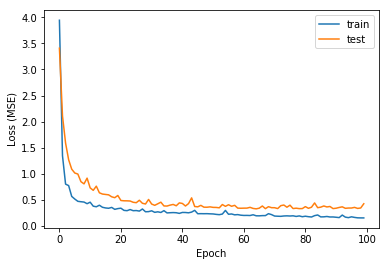

In [44]:
mse_test = history.__dict__['history']['val_loss']
mse_train = history.__dict__['history']['loss']
params = history.__dict__['params']

plt.plot(mse_train)
plt.plot(mse_test)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend(['train','test'])

print("Best Train Scores")
print("Score:", np.min(mse_test))
print("Epoch:",np.argmin(mse_test))